def of trust:
	let G = (V,E)
	for all u,v in V
		(u,v) in E iff (u has verified v's public key IN PERSON) and (u trusts v to relay incoming key information with integrity [fudge factor: n% of the time?])

note: defines a directed network, but reciprocity should be high

for a given network G:
	let s, t in G st s wants t's public key and (s,t) not in E
	want to know the number of paths between s and t in the network
		caveats: we don't know the whole network (local info only); we don't know which nodes should not be trusted (untrusted principle)

		
PATH COUNTING

In [121]:
import numpy as np
import networkx as nx
import rsa
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [167]:
class TNNode():
    
    def __init__(self,node_id):
        self.id = node_id
        self.private_key = None
        self.public_key = None
        self.neighbors = set()
        self.neighbors_ids = set()
        
        self.is_eve = False
        
        self.generate_keys()
        
    def generate_keys(self):
        self.public_key, self.private_key = rsa.newkeys(16)
    
    '''
    simulates high-fidelity in-person key transfer
    no trust assumptions yet
    '''
    def add_public_key_in_person(self,t_node):
        self.neighbors.add(t_node)
        self.neighbors_ids.add(t_node.id)
    
    '''
    tell me how many *paths* there are from me to some destination node
    naive implementation (assumes no eves)
    '''
    def count_paths_to(self,dest_id):
        #since this is a surrogate for trust, and we're just trying to find keys, infinite trust for already-known keys
        if self.id == dest_id:
            return float('inf')
        if dest_id in self.neighbors_ids:
            return float('inf')
        
        #now we just have to ask our neighbors how many paths there are
        paths = 0
        for neighbor in self.neighbors:
            paths += neighbor.path_count_interm(set(),dest_id)
            
        return paths
            
    '''
    I have been asked by a neighbor to count the number of paths to this person
    '''
    def path_count_interm(self,nodes_visited:set,dest_id):
        if dest_id == self.id:
            return 1#I have 1 path to myself (just a base case so everything works out fine)
        
        #otherwise I'll have to ask my neighbors
        nodes_visited.add(self)
        paths = 0
        for neighbor in (self.neighbors - nodes_visited):
            paths += neighbor.path_count_interm(nodes_visited,dest_id)
        
        return paths

In [124]:
def generate_rand_graph_from_deg_dist(num_nodes,dist = lambda: scipy.stats.truncnorm.rvs(0,float('inf'),loc=3,scale=3),approx_reciprocity=1.):
    #use the social network rand gen algorithm to make a new network
    G = [TNNode(i) for i in range(num_nodes)]
    
    #assign a degree to each node
    degrees = [max(1,int(dist())) for i in range(num_nodes)]#make sure everything is connected to at least one
    connections_left_to_make = {i for i in range(num_nodes)}#these nodes all have connections left to make
    total_connections_to_make = sum(degrees)
    
    #randomly connect the nodes according to their degrees
    connections_made = 0
    while (connections_made < total_connections_to_make) and (len(connections_left_to_make) > 1):
        #pick a random starter node
        i = np.random.choice(list(connections_left_to_make))
        #pick a random other node to assign to
        assign_to = G[np.random.choice(list(connections_left_to_make))]
        G[i].add_public_key_in_person(assign_to)
        connections_made += 1
        degrees[i] -= 1
        if degrees[i] == 0:
            connections_left_to_make.remove(i)
        
        #reciprocity guarantees based on the given number
        if np.random.uniform(0,1) < approx_reciprocity:
            #then add the edge going back to i
            assign_to.add_public_key_in_person(G[i])
            connections_made += 1
            degrees[assign_to.id] -= 1
            if degrees[assign_to.id] == 0:
                connections_left_to_make.remove(assign_to.id)
    
    return G

In [133]:
def convert_to_nx_graph(TNG):
    nxG = nx.DiGraph()
    nxG.add_nodes_from([node.id for node in TNG])
    for node in TNG:
        for connection in node.neighbors:
            nxG.add_edge(node.id,connection.id)
    
    return nxG

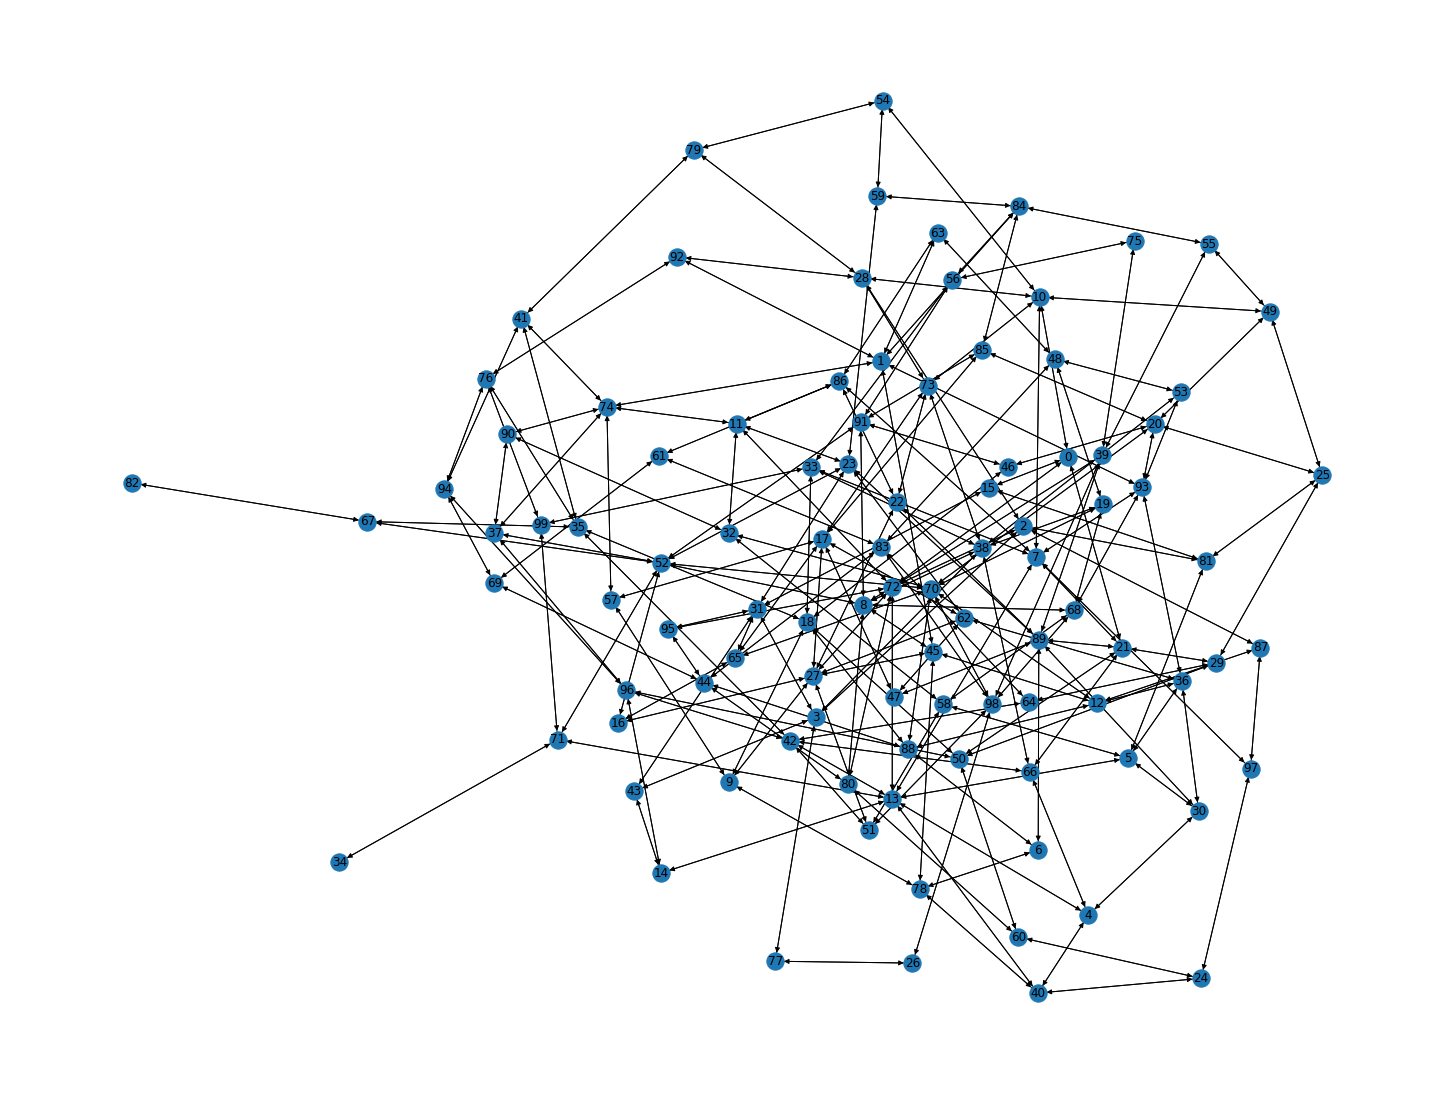

In [171]:
np.random.seed(0)
test_G = generate_rand_graph_from_deg_dist(100)
# test_G = [TNNode(i) for i in range(5)]
# test_G[0].add_public_key_in_person(test_G[1])
# test_G[1].add_public_key_in_person(test_G[0])
# test_G[1].add_public_key_in_person(test_G[2])
# test_G[1].add_public_key_in_person(test_G[3])
# test_G[1].add_public_key_in_person(test_G[4])
# test_G[2].add_public_key_in_person(test_G[3])
# test_G[3].add_public_key_in_person(test_G[1])
# test_G[3].add_public_key_in_person(test_G[2])
# test_G[4].add_public_key_in_person(test_G[1])
plt.figure(figsize=(20,15))
nx.draw(convert_to_nx_graph(test_G),with_labels=True)

In [172]:
test_G[34].count_paths_to(82)

4